# Simple RNN

In ths notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

In [18]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
np.linspace(0,10,5)

array([ 0. ,  2.5,  5. ,  7.5, 10. ])

In [20]:
N = 4
np.zeros(N)

array([0., 0., 0., 0.])

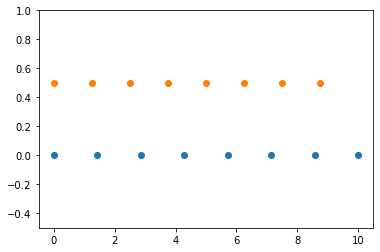

In [21]:
N = 8
y = np.zeros(N)
x1 = np.linspace(0, 10, N, endpoint = True)
x2 = np.linspace(0, 10, N, endpoint = False)

plt.plot(x1, y, 'o')
plt.plot(x2, y+0.5, 'o')
plt.ylim([-0.5, 1])
plt.show()

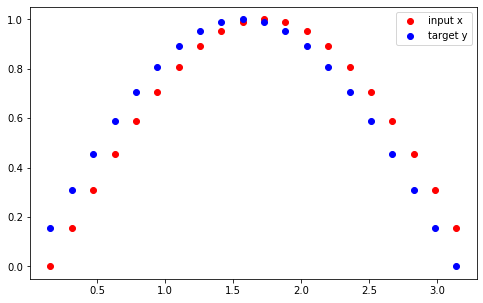

In [22]:
seq_length = 20

n = np.linspace(0, np.pi, seq_length+1) # (21,) like a 1 row with 21 columns
data = np.sin(n)
data.resize((seq_length+1),1) # (21,1)

x = data[:-1] # all but the last piece (20x1)
y = data[1:] # all but the first (20x1)

plt.figure(figsize=(8,5))
plt.plot(n[1:], x, 'ro', label = 'input x')
plt.plot(n[1:], y, 'bo', label = 'target y')
plt.legend()
plt.show()


---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_size** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_size)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [23]:
a = torch.tensor([1, 2, 3, 4])
a = a.view(1, 4)
print('a.shape: {} \na.squeeze().shape: {} \na.unsqueeze().shape: {}'.format(a.shape, a.squeeze().shape,a.unsqueeze(1).shape))

a.shape: torch.Size([1, 4]) 
a.squeeze().shape: torch.Size([4]) 
a.unsqueeze().shape: torch.Size([1, 1, 4])


In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # input (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_size)
        # r_out (batch_size, seq_length, hidden_size)
        
        batch_size= x.size(0)
        
        r_out, hidden = self.rnn(x, hidden)
        # flatting step for fully connected layer
        # shape output to be (batch_size*seq_length, hidden_size)
        r_out = r_out.view(-1, self.hidden_size) 
        
        output = self.fc(r_out)
        
        return output, hidden
    

### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [25]:
# test that dimensions are as expected
test_rnn = RNN(input_size=2, output_size=4, hidden_size=8, n_layers=2)

seq_length = 10

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 2))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None) # input (batch_size, seq_length, input_size)
print('Output size: ', test_out.size()) # (batch_size*seq_length, output_size)
print('Hidden state size: ', test_h.size()) # (batch_size, time_step, hidden_size)

Input size:  torch.Size([1, 10, 2])
Output size:  torch.Size([10, 4])
Hidden state size:  torch.Size([2, 1, 8])


---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [26]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_size=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_size, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.


In [27]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [28]:
for batch_i, step in enumerate(range(5)):
    print(batch_i, step)

0 0
1 1
2 2
3 3
4 4


In [29]:
seq_length = 10
time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # input_size=1
data.shape


(11, 1)

In [35]:


def train(rnn, n_steps, seq_length, print_every):
    
    # initialize the hidden state
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1))
        
        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # outputs from rnn
        prediction, hidden = rnn(x_tensor, hidden)
        
        hidden = hidden.data
        
        optimizer.zero_grad()
        loss = criterion(prediction, y_tensor)
        loss.backward()
        optimizer.step()
        
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.', label = 'input x') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.', label = 'predictions x') # predictions
            plt.legend()
            plt.show()
    
    return rnn
        
        

In [36]:
seq_length = 10
time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # input_size=1
data.shape

x = data[:-1]
y = data[1:]

x_tensor = torch.Tensor(x).unsqueeze(0) # 1,sep_length,
y_tensor = torch.Tensor(y)

Loss:  0.0007652275380678475


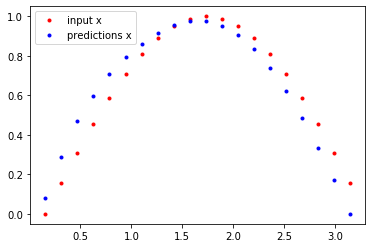

Loss:  0.0002037493250099942


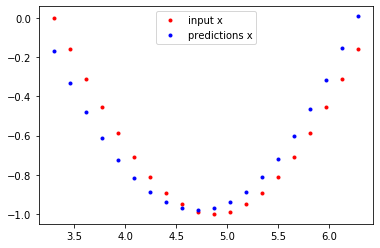

Loss:  0.0004807119257748127


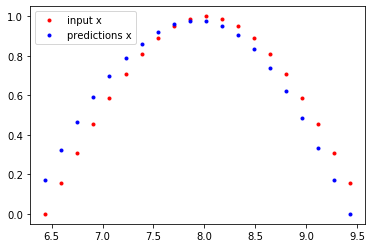

Loss:  0.00019613656331785023


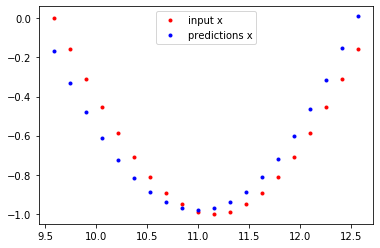

Loss:  0.0004731118679046631


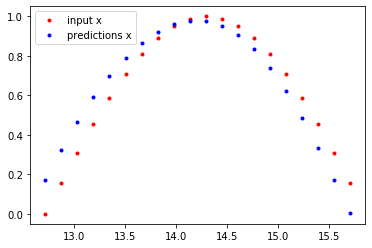

Loss:  0.00019131395674776286


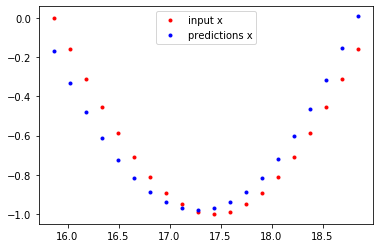

Loss:  0.0004604148562066257


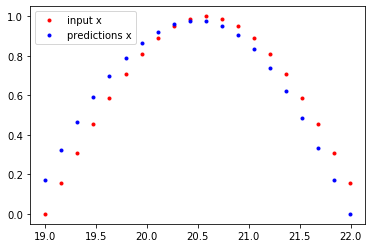

Loss:  0.00018843365251086652


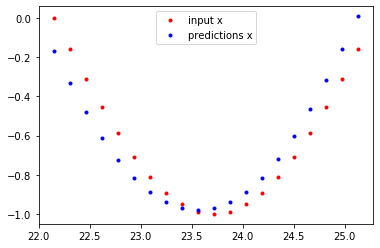

Loss:  0.00044764476479031146


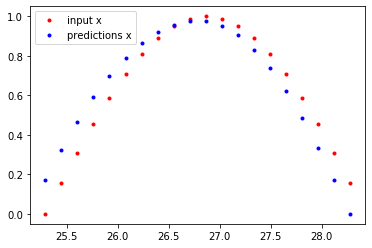

Loss:  0.00018381510744802654


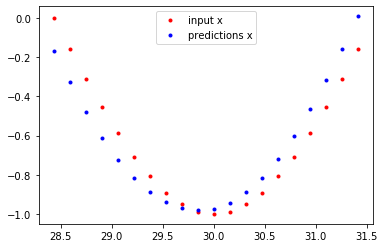

Loss:  0.00043843252933584154


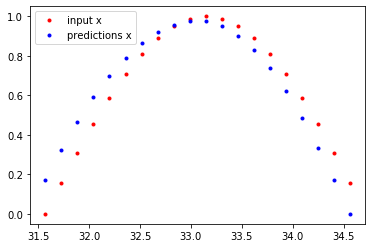

Loss:  0.00017582719738129526


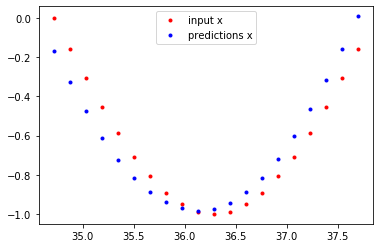

Loss:  0.0004317796847317368


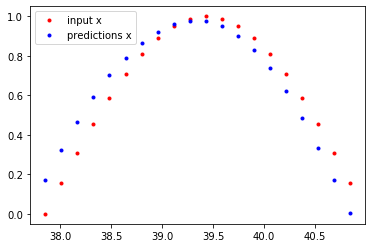

Loss:  0.00016683674766682088


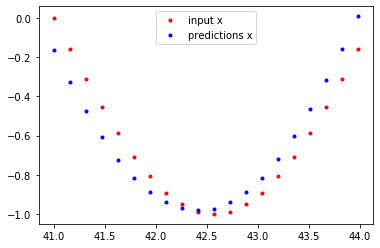

Loss:  0.0004245322779752314


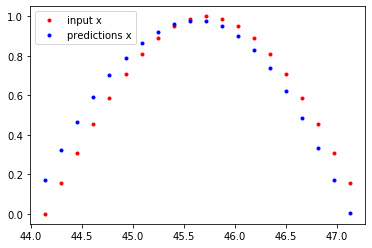

Loss:  0.00015953117690514773


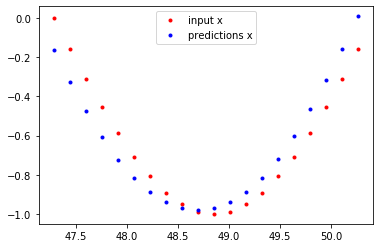

Loss:  0.0004150596505496651


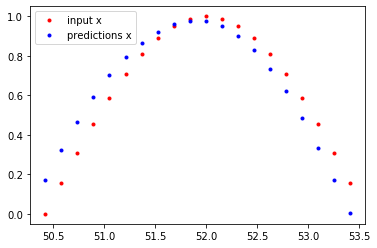

Loss:  0.00015411173808388412


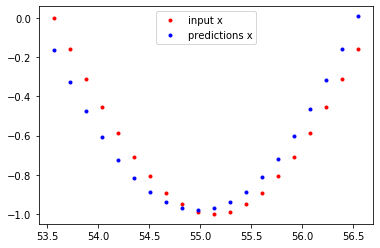

Loss:  0.00040392630035057664


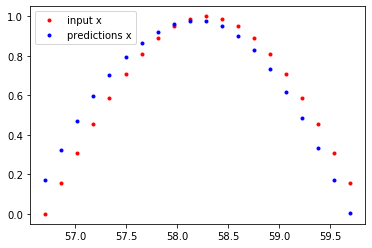

Loss:  0.00015013688243925571


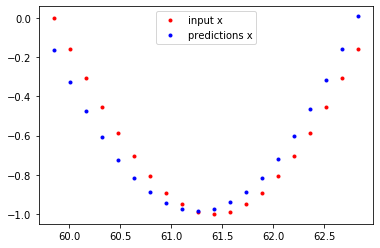

In [41]:
# train the rnn and monitor results
n_steps = 20
print_every = 1
seq_length = 20

trained_rnn = train(rnn, n_steps, seq_length, print_every)

In [39]:
20*np.pi

62.83185307179586